In [20]:
#Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.regularizers import l2

In [21]:
#setting seed for reproducibility (Keras, 2025)
SEED = 44
tf.keras.utils.set_random_seed(SEED)

In [22]:
#Loading data
sb_df = pd.read_csv("../starbucks_open_7year.csv")
print(sb_df.isna().sum()) #verifying no missing data

Unnamed: 0    0
Date          0
Open          0
Time          0
dtype: int64


In [23]:
#Data prepration
sb_df["Date"] = pd.to_datetime(sb_df["Date"]) #(Joseph, 2022)
sb_df = sb_df.set_index("Date").sort_index() #sorting by date
sb_df["Log_Open"] = np.log(sb_df["Open"]) #(Numpy, 2024) Log transformation as stock prices exhibit exponential growth (Fama, 1965)
data = sb_df["Log_Open"]
sb_df.head()

,Unnamed: 0,Open,Time,Log_Open
Date,,,,
2017-11-13,0,56.81,1.510531e+09,4.039712
2017-11-14,1,56.47,1.510618e+09,4.033710
2017-11-15,2,56.82,1.510704e+09,4.039888
2017-11-16,3,56.92,1.510790e+09,4.041647
2017-11-17,4,57.24,1.510877e+09,4.047253


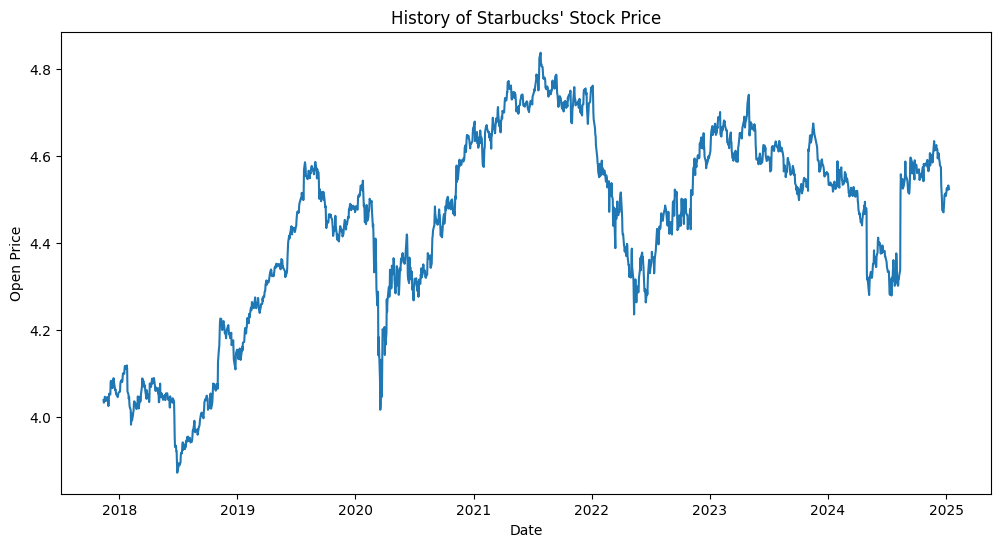

In [24]:
#Visualisation
plt.figure(figsize=(12, 6))
plt.plot(sb_df["Log_Open"])
plt.title("History of Starbucks' Stock Price")
plt.xlabel("Date")
plt.ylabel("Open Price")
plt.show()

In [25]:
#Normalising data
scaler = MinMaxScaler(feature_range=(0, 1)) #for faster convergence scaled between 0 and 1 (Jeyaraman, 2024)
scaled_data = scaler.fit_transform(sb_df[["Log_Open"]])

#Adding time series sequence
def create_sequences(data, seq_length):
  X, Y = [], []
  for i in range(len(data)- seq_length-1):
    X.append(data[i:(i+seq_length), 0])
    Y.append(data[i+seq_length,0])
  return np.array(X), np.array(Y)

seq_length = 60 #last 2 months used for prediction
X, Y = create_sequences(scaled_data, seq_length)

In [26]:
#train, validate and test split
train_size = 0.7
validation_size = 0.15
test_size = 0.15

train_end = int(len(scaled_data) * train_size)
val_end = int(len(scaled_data)* (train_size + validation_size))

X_train, Y_train = X[:train_end], Y[:train_end]
X_val, Y_val = X[train_end:val_end], Y[train_end:val_end]
X_test, Y_test = X[val_end:], Y[val_end:]

#Reshaping for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print ("Training Data", {X_train.shape}, {Y_train.shape})
print ("Validation Data", {X_val.shape}, {Y_val.shape})
print ("Testing Data", {X_test.shape}, {Y_test.shape})

Training Data {(1260, 60, 1)} {(1260,)}
Validation Data {(270, 60, 1)} {(270,)}
Testing Data {(209, 60, 1)} {(209,)}


In [27]:
#Creating a novel neural network using LSTM layers fro time series forecasting
def novel_model(seq_length):
  model = Sequential()
  model.add(LSTM(100, activation="relu", return_sequences=True, recurrent_dropout=0.2, input_shape=(seq_length, 1)))
  model.add(Dropout(0.2))

  #Second layer
  model.add(LSTM(80,activation ="relu"))
  model.add(Dropout(0.3))

  #Dense layers to further compress the output (gradual reduction)
  model.add(Dense(50, activation="relu", kernel_regularizer=l2(0.01)))
  model.add(Dense(30, activation="relu"))
  model.add(Dense(15, activation="relu"))

  #Output layer
  model.add(Dense(1))
  model.compile(optimizer="adam", loss="mean_squared_error")
  return model

model = novel_model(seq_length)
model.summary()

/Users/reghunotraghu/Documents/college_projects/dl-group-project/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 80)             │        57,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         4,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,781 (409.30 KB)

 Trainable params: 104,781 (409.30 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
#Fitting and training the model
early_stop = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True) #Early stopping to prevent overfitting and stopping the model from memorising training data instead of learning general patterns

history= model.fit(X_train, Y_train, epochs=100,
                   batch_size=32, validation_data=(X_val, Y_val),
                   callbacks=[early_stop],
                   verbose=1
                   )

Epoch 1/100


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7147 - val_loss: 0.3791
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3355 - val_loss: 0.2149
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1925 - val_loss: 0.1223
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1092 - val_loss: 0.0691
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0624 - val_loss: 0.0377
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0358 - val_loss: 0.0249
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0220 - val_loss: 0.0135
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0157 - val_loss: 0.0097
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0110 - val_loss: 0.0065
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0093 - val_loss: 0.0048
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0066 - val_loss: 0.0035
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0

In [29]:
#Comparing losses
train_loss = model.evaluate(X_train, Y_train)
val_loss = model.evaluate(X_val, Y_val)
test_loss = model.evaluate(X_test, Y_test)

print("Comparing Losses:")
print(f"Train Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")
print(f"Test Loss: {test_loss}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011    
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026     
Comparing Losses:
Train Loss: 0.0019774476531893015
Validation Loss: 0.0011550678173080087
Test Loss: 0.002780481707304716


In [30]:
#Evaluating scaled data
Y_pred = model.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2= r2_score(Y_test, Y_pred)
mape = mean_absolute_percentage_error(Y_test, Y_pred)

print("Model performance on scaled data:")
print(f"MAE:{mae:.4f}")
print(f"MSE:{mse:.4f}")
print(f"RMSE:{rmse:.4f}")
print(f"R2 Score:{r2:4f}")
print(f"MAPE:{mape:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Model performance on scaled data:
MAE:0.0306
MSE:0.0024
RMSE:0.0491
R2 Score:0.793467
MAPE:0.0512


In [31]:
#Evaluating actual price predictions
train_predict = model.predict(X_train)
val_predict = model.predict(X_val)
test_predict = model.predict(X_test)

#Inversing prediction from vector to actual price to test scores
train_predict = scaler.inverse_transform(train_predict)
Y_train_actual = scaler.inverse_transform(Y_train.reshape(-1,1))
val_predict = scaler.inverse_transform(val_predict)
Y_val_actual = scaler.inverse_transform(Y_val.reshape(-1,1))
test_predict = scaler.inverse_transform(test_predict)
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1,1))

mae_actual = mean_absolute_error(Y_test_actual, test_predict)
mse_actual = mean_squared_error(Y_test_actual, test_predict)
rmse_actual = np.sqrt(mse_actual)
r2 = r2_score(Y_test_actual, test_predict)
mape = mean_absolute_percentage_error(Y_test_actual, test_predict)

print("Model performance on actual price prediction:")
print(f"MAE: {mae_actual:.4f}")
print(f"MSE: {mse_actual:.4f}")
print(f"RMSE: {rmse_actual:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Model performance on actual price prediction:
MAE: 0.0295
MSE: 0.0022
RMSE: 0.0473
R2 Score: 0.7935
MAPE: 0.0066


In [32]:
#Code for actual prediction
def predict_stock(model, end_sequence, future_days):
  predictions = []
  current_sequence = end_sequence.copy()

  for i in range(future_days):
    current_input = current_sequence.reshape((1, seq_length,1))
    new_prediction = model.predict(current_input)[0,0]
    predictions.append(new_prediction)

    current_sequence = np.roll(current_sequence,-1)
    current_sequence[-1] = new_prediction
  return scaler.inverse_transform(np.array(predictions).reshape(-1,1))

end_sequence = scaled_data[-seq_length:]
future_predictions = predict_stock(model, end_sequence, 30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

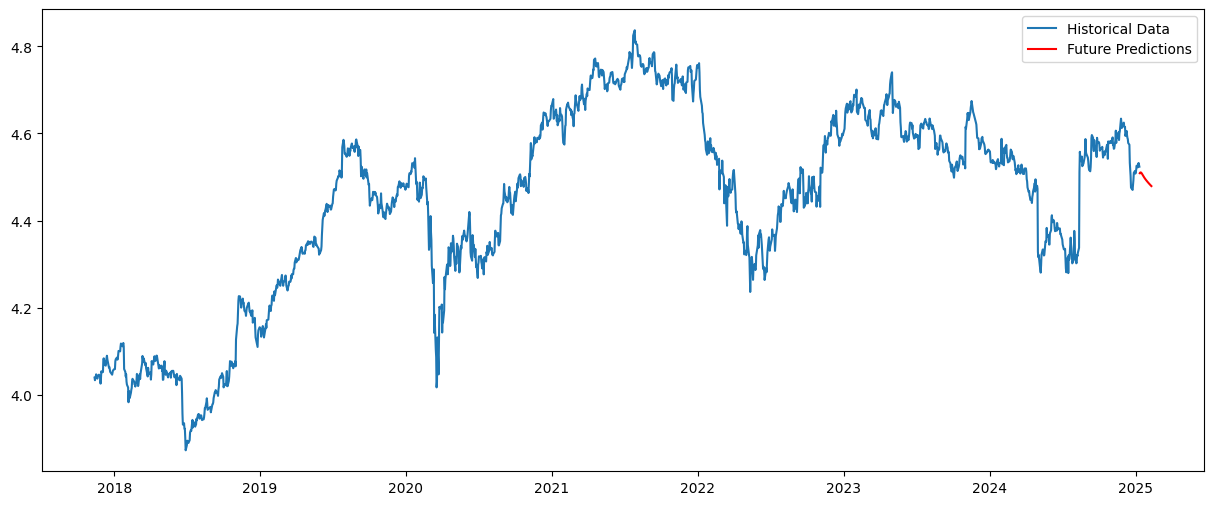

In [33]:
#Ploting future predicitons
plt.figure(figsize=(15, 6))
plt.plot(sb_df.index, sb_df["Log_Open"], label="Historical Data")
future_dates = pd.date_range(start=sb_df.index[-1], periods=31, freq="D")[1:]
plt.plot(future_dates, future_predictions, "r-", label="Future Predictions")
plt.legend()
plt.show()